# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

- A12785571, ekfu@ucsd.edu, Edwin Fu
- A12623303, jcloo@ucsd.edu, Joel Loo
- A13589612, bfbarry@ucsd.edu, Brian Barry
- A12690911, zes004@ucsd.edu, Sunny Sun
- A13736482, roz021@ucsd.edu, Roy Zhang
- A13014470, khh007@ucsd.edu, Kevin Huang


## Introduction: Background

From 2013-2018, the United States of America has gone through a period of time when there were over 260,000 reported occurrence of gun violence. With so many reported incidents within the span of only 5 years, there needs to be a way for citizens to find where all these incidents are occurring without having to sift through heaps of data. People should be aware of where areas of high gun violence rates are occurring and how possible prevention can occur. We seek to find out whether or not gun violence rates, household income level, and population level are correlated and if so, can there be a way to lower the gun violence rates in those areas. To operationalize this, we are using gun violence rates, household income levels, and population counts as our metrics since all three can be utilized for our research question of whether there is a correlation between income and gun violence within an area of the United States.

To start with our analysis, we will start by importing some Python library packages for analyzing and graphing our data:


# Library imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

plotly.tools.set_credentials_file(username='jcloo', api_key='6Qa08K4DBMMNjPHL2p0T')


In [3]:
# Configure Seaborn library
sns.set()
sns.set_context('talk')

In [60]:
#read datasets
url = "https://doc-0k-88-docs.googleusercontent.com/docs/securesc/a4oc2hqjnhqph43vaufe9fs3nelfc15u/n2em47vd7bqh0bu7a279knuoq26ugn8a/1552176000000/12632076152020903193/12632076152020903193/1KXzWFA-RIXwBXuOu81-E-MYi-e7WVfTj?e=download&nonce=1r1nehh1hfp4m&user=12632076152020903193&hash=uc1qcip4tede3ao389g85jg856941gf0"
gun_data = pd.read_csv("datasets/gun-violence-data_01-2013_03-2018.csv")
income_data = pd.read_csv("datasets/kaggle_income.csv", encoding = "ISO-8859-1")
rent_data = pd.read_csv("datasets/price.csv", encoding = "ISO-8859-1")
states = pd.read_csv("datasets/states.csv")
county_fips = pd.read_excel("datasets/fips_data.xlsx")

In [9]:
#Remove null values
#gun_data.dropna(inplace = True)
#income_data.dropna(inplace = True)
gun_data_abbrev = gun_data[['state', 'city_or_county','n_killed', 'n_injured']]

## Data Description

The datasets we are using are US State Population, Gun Violence, US Household Income. Details include state, county, state population, household income, its mean, its median, and its standard deviation. We will be using these sets to find out if the frequency of gun violence has a direct correlation with household income with the effect of population density.
These datasets can be obtained on:
US State Population - https://www.kaggle.com/lucasvictor/us-state-populations-2018?fbclid=IwAR2QTVJfUDl20U0YXWy804-poFuxP1f5IDnJecWh0AMGgoJImjTS0DVNsos
Gun Violence - 
https://www.kaggle.com/jameslko/gun-violence-data
US Household Income -
https://www.kaggle.com/goldenoakresearch/us-household-income-stats-geo-locations


In [11]:
#gun_data[(gun_data["city_or_county"]=="Mckeesport") & (gun_data["state"]=="Pennsylvania")]

# # clean/merge datasets by city

In [113]:
#CLEANING UP COUNTY DATAFRAME 


#county_fips = county_fips[['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6']]
#county_fips.columns = ['state code', 'county code', 'county name']
#county_fips.dropna(inplace=True)
#county_fips = county_fips.iloc[2:]
county_fips.head()
#county_fips.to_csv('fips_data.csv', index = None, header=True)

,state code,county code,county name,FIPS
5,01,000,Alabama,01000
6,01,001,Autauga County,01001
7,01,003,Baldwin County,01003
8,01,005,Barbour County,01005
9,01,007,Bibb County,01007


In [19]:
#TODO: match rows/merge by City
#loop through income data and aggregate a dataframe by city

city_metrics = pd.DataFrame()
count = 0

for index, income_row in income_data.iterrows():
    city = income_row['City']
    state = income_row['State_Name']
    code = income_row['State_ab']
    county = income_row['County']
    lat = income_row['Lat']
    long = income_row['Lon']
    
   # print(city)
    #print(state)
    
    #get dataframe of incident rows with matching state and city
    incidents = gun_data_abbrev.loc[(gun_data['state']  == state) & (gun_data['city_or_county'] == city)]
    #print(incidents)
    #compute each city's total incidents and total deaths/ whatever metrics for violence we want to use
    num_incidents = incidents.shape[0]
    total_killed = incidents['n_killed'].sum()
    total_injured = incidents['n_injured'].sum()

    #extract income metrics for city
    mean_inc = income_row['Mean']
    median_inc = income_row['Median']
    stdev_inc = income_row['Stdev']
    
    #construct row of the values we want to describe the city
    city_row = pd.DataFrame(columns = ['state','city', 'county', 'code','mean_inc','median_inc','stdev_inc','num_incidents','total_killed','total_injured', 'lat', 'long'])
    city_row.loc[0] = [state,city,county,code,mean_inc,median_inc,stdev_inc,num_incidents,total_killed,total_injured, lat, long]
    #print(city_row)
    
    city_metrics = city_metrics.append(city_row)

In [129]:
#subset rent data to take only large city (avoid duplicates)

city_metrics_rent = pd.DataFrame()
count = 0

for index, rent_row in rent_data.iterrows():
    city = rent_row['City']
    state_abbrev = rent_row['State']
    
    #convert to full state name by comparing to states list
    state = states.loc[states['Abbreviation'] == state_abbrev]['State'].values[0]
    
#    print(city)
#    print(state)
    
    #get dataframe of incident rows with matching state and city
    incidents = gun_data_abbrev.loc[(gun_data_abbrev['state']  == state) & (gun_data_abbrev['city_or_county'] == city)]
    the_county = city_metrics.loc[(city_metrics['state'] == state) & (city_metrics['city'] == city)]
    #print(the_county)
    #compute each city's total incidents and total deaths/ whatever metrics for violence we want to use
    num_incidents = incidents.shape[0]
    total_killed = incidents['n_killed'].sum()
    total_injured = incidents['n_injured'].sum()
    


    #extract rent metrics for city
    latest_rent = rent_row['January 2017']
    
    #extract county for city
    if the_county.empty != True:
        county_list = the_county.at[0,'county']
        #print(the_county)
        #print(the_county.at[0, 'county'])
        #print(the_county.at[0, 'county'])
        #print("length of most counties is ", len(county_list))
        #print("most of the counties are ", county_list)
        if type(county_list) == str:
            county = county_list
        else:
            county = county_list[0]
        if len(county) == 1:
            print(type(county_list))
            print("size of list is ", len(county_list))
            print("county list is ", county_list)
            print(county)

        

    
    #construct row of the values we want to describe the city
    city_row = pd.DataFrame(columns = ['state','city', 'county', 'latest_rent','num_incidents','total_killed','total_injured'])
    city_row.loc[0] = [state,city,county,latest_rent,num_incidents,total_killed,total_injured]
    city_metrics_rent = city_metrics_rent.append(city_row)

In [130]:
city_metrics_rent.head()
city_metrics_rent.to_csv('updated_city_metrics_rent.csv', index = None, header=True)
#city_metrics_rent.loc[(city_metrics_rent['county'] == 'Mobile County')]

In [132]:

county_data = pd.DataFrame()

county_fips['state code'] = county_fips['state code'].apply(lambda x: str(x).zfill(2))
county_fips['county code'] = county_fips['county code'].apply(lambda x: str(x).zfill(3))
county_fips['FIPS'] = county_fips['state code'] + county_fips['county code']

county_fips.head()


for index, FIPS_row in county_fips.iterrows():
    county = FIPS_row['county name']
    code = FIPS_row['FIPS']
    
    all_counties = city_metrics_rent.loc[(city_metrics_rent['county'] == county)]
    #print(all_counties)
    num_incidents = all_counties['num_incidents'].sum()
    
    to_add = pd.DataFrame(columns = ['county', 'fips', 'num_incidents'])
    to_add.loc[0] = [county, code, num_incidents]
    county_data = county_data.append(to_add)
    

    

In [135]:
county_data.to_csv('county_incidents.csv', index = None, header=True)

,county,fips,num_incidents
0,Alabama,01000,0
0,Autauga County,01001,2994
0,Baldwin County,01003,0
0,Barbour County,01005,805
0,Bibb County,01007,0
0,Blount County,01009,0
0,Bullock County,01011,0
0,Butler County,01013,75
0,Calhoun County,01015,1
0,Chambers County,01017,55


In [31]:
city_metrics.loc[(city_metrics['county'] == 'Mobile County')]

,state,city,county,code,mean_inc,median_inc,stdev_inc,num_incidents,total_killed,total_injured,lat,long
0,Alabama,Chickasaw,Mobile County,AL,38773,30506,33101,1,0,0,30.771450,-88.079697
0,Alabama,Satsuma,Mobile County,AL,63919,52814,47707,0,0,0,30.874343,-88.009442
0,Alabama,Dauphin Island,Mobile County,AL,77948,67225,54270,0,0,0,30.250913,-88.171268
0,Alabama,Mobile,Mobile County,AL,53330,38231,50855,560,161,303,30.668426,-88.100226
0,Alabama,Satsuma,Mobile County,AL,59567,52275,43545,0,0,0,30.854581,-88.109929
0,Alabama,Mobile,Mobile County,AL,55230,47636,45298,560,161,303,30.581533,-88.212780
0,Alabama,Bayou La Batre,Mobile County,AL,50047,35147,43788,1,0,0,30.407586,-88.263271


## Data Visualization

In [51]:
city_metrics['mean_inc'] = pd.to_numeric(city_metrics['mean_inc'])
city_metrics['num_incidents'] = pd.to_numeric(city_metrics['num_incidents'])


In [52]:
city_metrics.dtypes

state             object
city              object
county            object
code              object
mean_inc           int64
median_inc        object
stdev_inc         object
num_incidents      int64
total_killed      object
total_injured     object
lat              float64
long             float64
dtype: object

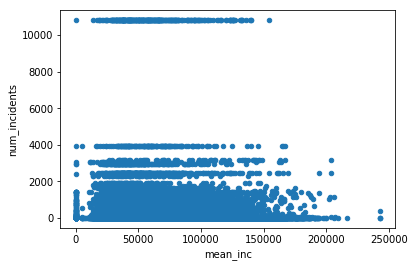

In [53]:
#TO-DO: Fix typeerror for seaborn plot

city_metrics.plot.scatter(x = 'mean_inc', y = 'num_incidents')

#inc_incidents_scat =  sns.lmplot(x ="mean_inc", y ="num_incidents", data =city_metrics, aspect = 1.5)

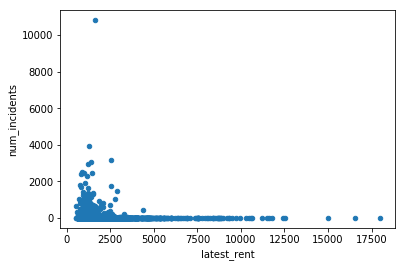

In [54]:
city_rent.plot.scatter(x = 'latest_rent', y = 'num_incidents')

In [134]:
#heatmap of US using plotly


colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]
endpts = list(np.linspace(1, 12, len(colorscale) - 1))
fips = county_data['fips'].tolist()
#values = df_sample['Unemployment Rate (%)'].tolist()
values = county_data['num_incidents'].tolist()

fig = ff.create_choropleth(
    fips = fips, values = values, scope = ['usa'],
    binning_endpoints = endpts, colorscale = colorscale,
    show_state_data = False,
    show_hover = True, centroid_marker = {
        'opacity': 0
    },
    asp = 2.9,
    title = 'USA by Unemployment %',
    legend_title = '% unemployed'
)
py.iplot(fig, filename = 'choropleth_full_usa')


/Users/royzhang/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


/Users/royzhang/anaconda3/lib/python3.7/site-packages/plotly/figure_factory/_county_choropleth.py:772: UserWarning:

Unrecognized FIPS Values

Whoops! It looks like you are trying to pass at least one FIPS value that is not in our shapefile of FIPS and data for the counties. Your choropleth will still show up but these counties cannot be shown.
Unrecognized FIPS are: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000

/Users/royzhang/anaconda3/lib/python3.7/site-packages/plotly/plotly/plotly.py:248: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/Users/royzhang/anaconda3/lib/python3.7/site-packages/plotly/plotly/plotly.py:248: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of chart

KeyboardInterrupt: 

In [37]:
city_metrics.columns

Index(['state', 'city', 'code', 'mean_inc', 'median_inc', 'stdev_inc',
       'num_incidents', 'total_killed', 'total_injured'],
      dtype='object')

# Correlation Analysis

In [39]:
#extract numeric data from city metrics and cast to int
income_vs_incidents = city_metrics[['mean_inc', 'median_inc', 'stdev_inc', 'num_incidents', 'total_killed', 'total_injured']]
income_vs_incidents = income_vs_incidents.astype('int64')
income_vs_incidents.head()

,mean_inc,median_inc,stdev_inc,num_incidents,total_killed,total_injured
0,38773,30506,33101,1,0,0
0,37725,19528,43789,2,0,3
0,54606,31930,57348,4,0,5
0,63919,52814,47707,0,0,0
0,77948,67225,54270,0,0,0


In [42]:
#compute correlation matrix
income_vs_incidents_corrs = income_vs_incidents.corr()
income_vs_incidents_corrs

,mean_inc,median_inc,stdev_inc,num_incidents,total_killed,total_injured
mean_inc,1.000000,0.541713,0.844316,-0.048590,-0.058784,-0.038566
median_inc,0.541713,1.000000,0.329265,-0.050644,-0.054388,-0.043277
stdev_inc,0.844316,0.329265,1.000000,-0.016017,-0.027067,-0.008635
num_incidents,-0.048590,-0.050644,-0.016017,1.000000,0.952464,0.982219
total_killed,-0.058784,-0.054388,-0.027067,0.952464,1.000000,0.902203
total_injured,-0.038566,-0.043277,-0.008635,0.982219,0.902203,1.000000


In [43]:
city_metrics_rent.columns

Index(['state', 'city', 'latest_rent', 'num_incidents', 'total_killed',
       'total_injured'],
      dtype='object')

In [45]:
rent_vs_incidents = city_metrics_rent[['latest_rent','num_incidents','total_killed','total_injured']]
rent_vs_incidents.head()


,latest_rent,num_incidents,total_killed,total_injured
0,2322,17,0,11
0,2753,1066,636,553
0,1632,10814,2104,10427
0,1430,2480,1144,1245
0,1212,2929,890,2318


## Ethics and Privacy
